In [1]:
from product.stock_category import StockCategory
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
from modeler.modeler import Modeler as m
import pickle
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
params = {"training_years":4}
product = StockCategory(params)
product.subscribe()

In [3]:
product.db.connect()
data = product.db.retrieve("transformed")
product.db.disconnect()

In [28]:
start = data["year"].min()
end = data["year"].max()
yearly_gap = 1
training_years = product.params["training_years"]
product.db.connect()
hmodels = product.db.retrieve("model")
encoder = pickle.loads(hmodels[hmodels["purpose"]=="encoder"]["model"].item())
product.db.disconnect()
for year in tqdm(range(2016,2017)):
    try:
        prediction_data = product.create_prediction_set(data,year,training_years,yearly_gap)
        refined_data = product.create_training_set(data,year,training_years,yearly_gap)
        print(year,refined_data["X"].index.size,prediction_data.index.size)
        models = []
        models.append(m.sk_classify(refined_data.copy(),multioutput=True))
#         models.append(m.xgb_classify(refined_data.copy(),multioutput=True))
#         models.append(m.light_classify(refined_data.copy(),multioutput=True))
#         cat_y = refined_data["y"].copy()
#         cat_y["y"] = [x[0] for x in encoder.inverse_transform(refined_data["y"])]
#         cat_data = {"X":refined_data["X"].copy(),"y":cat_y[["y"]]}
#         models.append(m.cat_classify(refined_data.copy(),multioutput=True))
        stuff = pd.DataFrame(models)
#         model = models["model"]
#         factors = list(refined_data["X"].columns)
#         prediction_data[factors].fillna(prediction_data[factors].mean(numeric_only=True),inplace=True)
#         predictions = encoder.inverse_transform(model.predict(prediction_data[factors]))
#         prediction_data["prediction"] = [x[0] for x in predictions]
#         prediction_data["score"] = models["score"].item()
#         sim = prediction_data[["year","quarter","ticker","prediction","score"]]
#         sim["training_years"] = training_years
    except Exception as e:
        print(str(e))

  0%|                                                                                                                                 | 0/1 [00:00<?, ?it/s]

2016 30489 7887


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:02<00:00, 182.71s/it]


In [29]:
stuff

,api,model,score
4,skl,MultiOutputClassifier(estimator=RandomForestCl...,0.986488


In [37]:
model = stuff["model"].iloc[0]
factors = list(refined_data["X"].columns)
prediction_data[factors].fillna(prediction_data[factors].mean(numeric_only=True),inplace=True)
prediction_data = prediction_data.groupby(["year","quarter","ticker"]).mean().reset_index()
predictions = encoder.inverse_transform(model.predict(prediction_data[factors]))
prediction_data["prediction"] = [x[0] for x in predictions]
prediction_data["score"] = stuff["score"].iloc[0].item()
sim = prediction_data[["year","quarter","ticker","prediction","score"]]

In [50]:
sim["prediction"] = [x if x in sim["prediction"].unique()[1:] else "None" for x in sim["prediction"]]

In [51]:
sim["prediction"].unique()

array(['None', '100Materials', '200Information Technology',
       '200Consumer Discretionary', '100Health Care',
       '100Information Technology', '200Health Care', '100Real Estate',
       '100Industrials', '100Financials', '100Consumer Staples',
       '100Consumer Discretionary', '100Communication Services',
       '500Consumer Discretionary', '100Utilities', '100Energy',
       '200Consumer Staples', '200Materials', '200Real Estate',
       '200Industrials'], dtype=object)

In [52]:
sim[sim["prediction"] == "None"].index.size /sim["prediction"].index.size

0.8003264417845484

In [4]:
data = data.dropna()

In [5]:
data.columns

Index(['AccumulatedOtherComprehensiveIncomeLossNetOfTax', 'Assets',
       'AssetsCurrent', 'CashAndCashEquivalentsAtCarryingValue',
       'EarningsPerShareBasic', 'EarningsPerShareDiluted',
       'EntityCommonStockSharesOutstanding', 'IncomeTaxExpenseBenefit',
       'LiabilitiesAndStockholdersEquity', 'LiabilitiesCurrent',
       'NetIncomeLoss', 'OtherAssetsNoncurrent',
       'RetainedEarningsAccumulatedDeficit', 'StockholdersEquity', 'year',
       'quarter', 'ticker', 'CommonStockValue', 'Goodwill',
       'PropertyPlantAndEquipmentNet', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30',
       'training_years'],
      dtype='object')

In [34]:
data["category"] = [value[0] for value in encoder.inverse_transform(data[[str(x) for x in range(numberss+1)]])]

In [39]:
categories = data["category"].unique()

In [42]:
cmap = {}
for i in range(len(categories)):
    cmap[categories[i]] = i 

In [43]:
data["color"] = [cmap[x] for x in data["category"]]

In [24]:
x_col = "AssetsCurrent"
y_col = "LiabilitiesCurrent"
z_col = "NetIncomeLoss"
color = "EarningsPerShareBasic"
data["x"] = data[x_col] / data["Assets"]
data["y"] = data[y_col] / data["Assets"]
data["z"] = data[z_col] / data["Assets"]
data["color"] = data[color] / data["AssetsCurrent"]

In [26]:
filtered = data[(data["x"] < 1) & (data["y"] < 1) & (data["z"] < 1) & (data["z"] > -1) & (data["color"] > -1)]

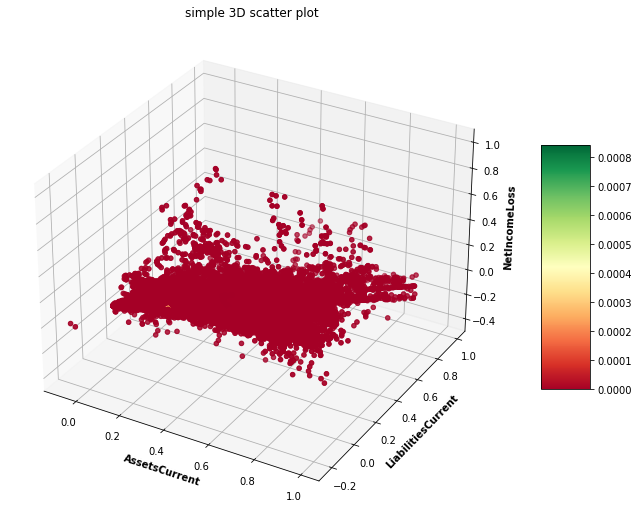

In [27]:

# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('RdYlGn')
 
# Creating plot
sctt = ax.scatter3D(filtered["x"], filtered["y"], filtered["z"],
                    c = filtered["color"],
                    cmap = my_cmap)
 
plt.title("simple 3D scatter plot")
ax.set_xlabel(x_col, fontweight ='bold')
ax.set_ylabel(y_col, fontweight ='bold')
ax.set_zlabel(z_col, fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

In [15]:
factors = list(cat_data["X"].columns)
prediction_data[factors].fillna(prediction_data[factors].mean(numeric_only=True),inplace=True)
predictions = model.predict(prediction_data[factors])

In [18]:
prediction_data["prediction"] = [x[0] for x in predictions]
sim = prediction_data[["year","quarter","ticker","prediction"]]

In [19]:
sim

,year,quarter,ticker,prediction
38,2016,1,AAPL,100Energy
39,2016,1,AAPL,100Energy
40,2016,1,AAPL,200Communication Services
41,2016,1,AAPL,200Communication Services
42,2016,2,AAPL,200Communication Services
...,...,...,...,...
42268,2016,4,PYPL,100Industrials
42273,2016,4,HPE,100Consumer Discretionary
42274,2016,4,HPE,100Consumer Discretionary
42279,2016,4,HPE,100Consumer Discretionary


In [4]:
refined_data["y"].drop(index=[x for x in range(0,refined_data["y"].index.size,4)])

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30482,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30485,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30486,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
